In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


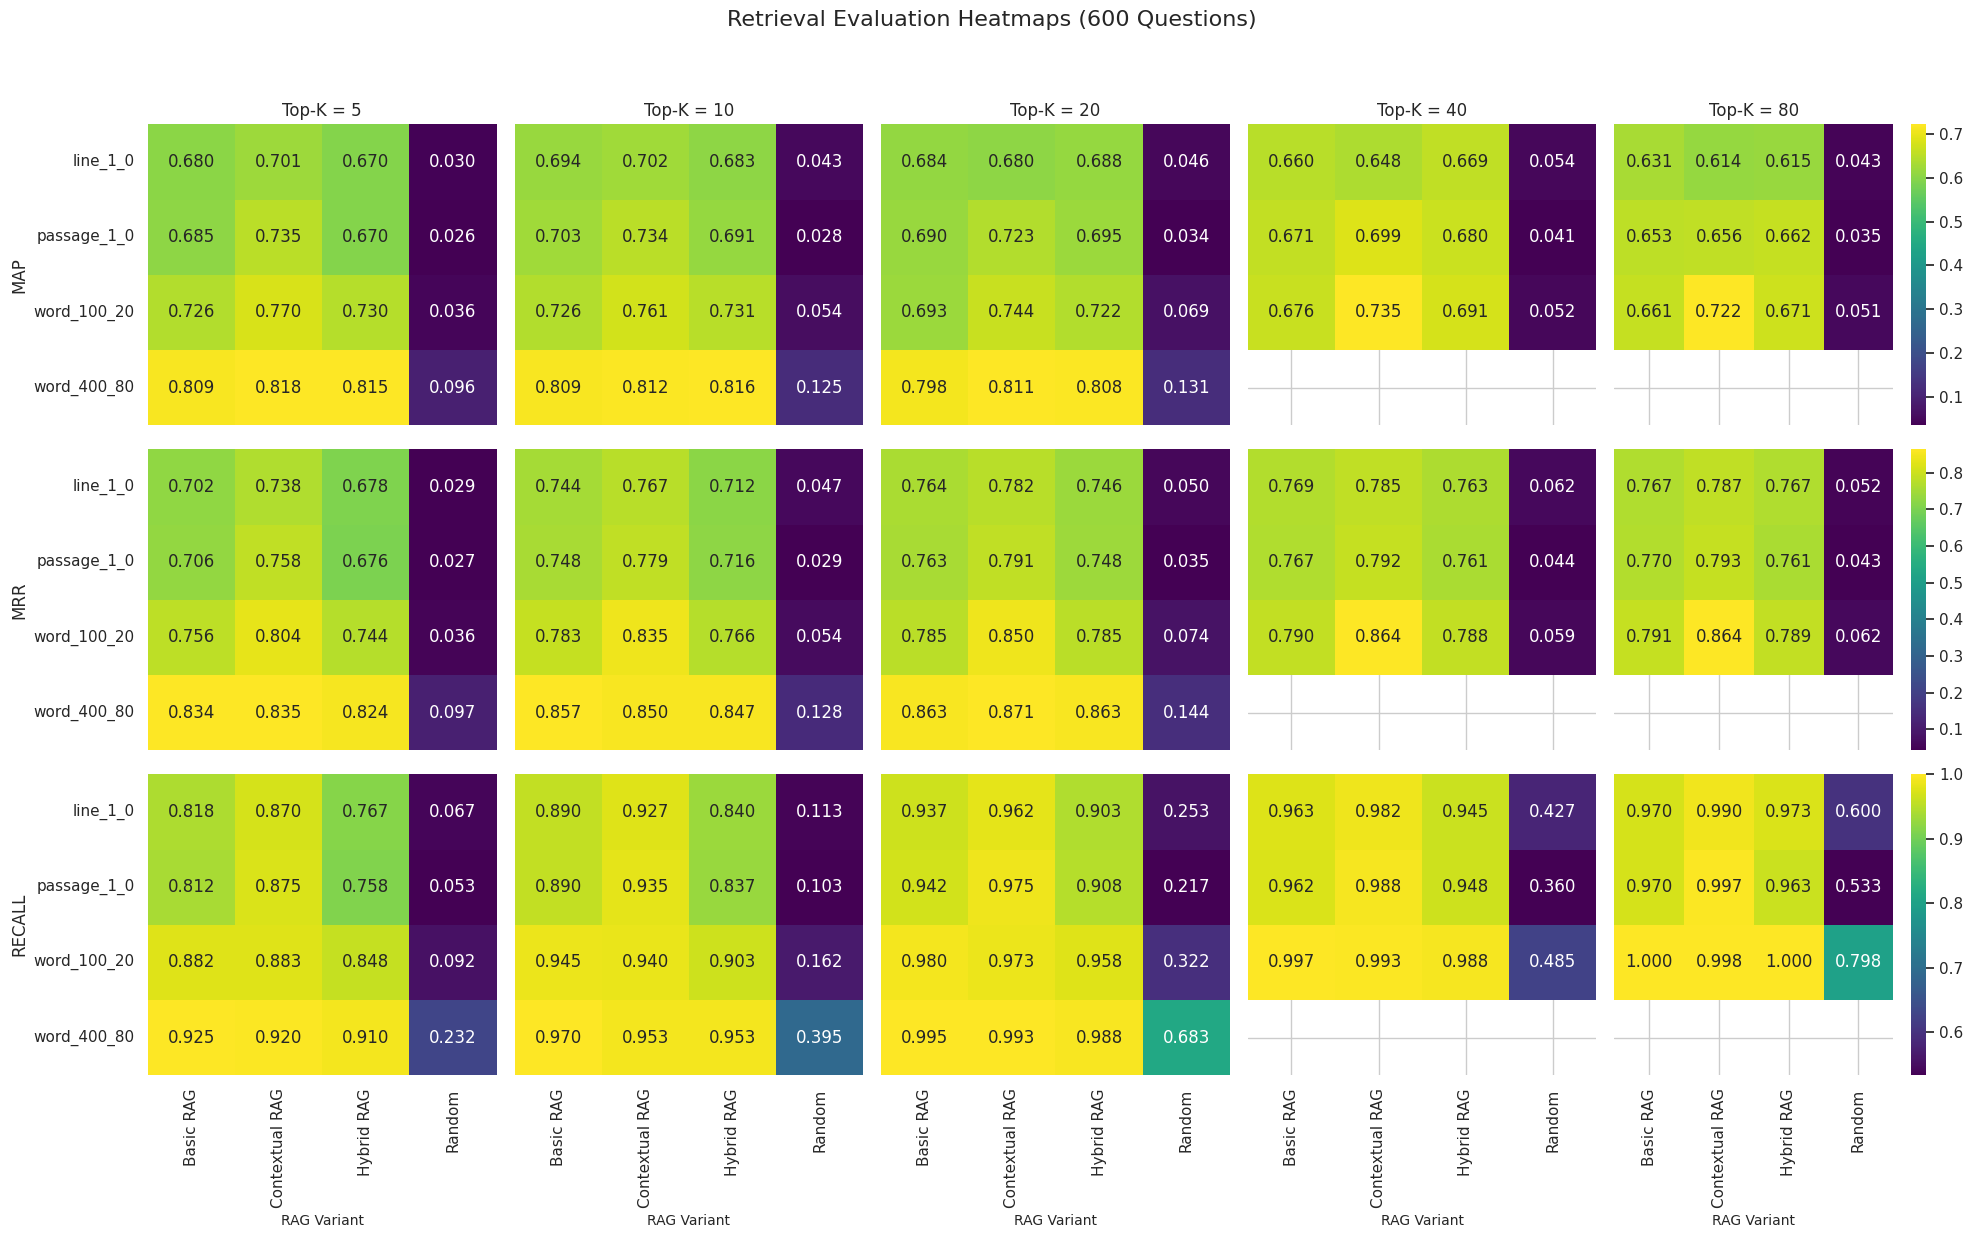

In [35]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-07-28_12-33-49/QwenQwen3-Embedding-4B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]
CMAP            = "viridis"

# ← Define your exact splitting‐row order here: ←
SPLITTING_ORDER = [
    "line_1_0",
    "passage_1_0",
    "word_50_10",
    "word_100_20",
    "word_400_80",
    "word_800_160",
]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

# 1) Gather all records
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    # detect which prefixes have all three metrics
    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{metric}" in df.columns for metric in METRICS))

    def mean_col(s: pd.Series) -> float:
        clean = (
            s.dropna()
             .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
             .astype(float)
        )
        return clean.mean()

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            records.append({
                "splitting": splitting,
                "topk"     : topk,
                "rag_type" : p,
                "metric"   : metric,
                "score"    : mean_col(df[col]) if col in df.columns else None
            })

results = pd.DataFrame(records)

# 2) Determine unique Top-K values
topks = sorted(results["topk"].unique())
rag_types = sorted(results["rag_type"].unique())

# 3) Enforce your splitting‐order (dropping any missing ones)
splittings = [s for s in SPLITTING_ORDER if s in results["splitting"].unique()]

# 4) Plot grid of heatmaps: rows=metrics, cols=topk
sns.set(style="whitegrid")
fig, axes = plt.subplots(
    nrows=len(METRICS),
    ncols=len(topks),
    figsize=(4 * len(topks), 4 * len(METRICS)),
    sharex="col",
    sharey="row"
)
axes = np.atleast_2d(axes)

for i, metric in enumerate(METRICS):
    for j, tk in enumerate(topks):
        ax = axes[i, j]
        sub = results[(results.metric == metric) & (results.topk == tk)]

        # pivot then reindex rows in your desired order
        pivot = sub.pivot_table(
            index="splitting",
            columns="rag_type",
            values="score",
            aggfunc="mean"
        ).reindex(index=splittings, columns=rag_types)

        if pivot.empty or pivot.isna().all().all():
            ax.axis("off")
            continue

        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap=CMAP,
            cbar=(j == len(topks)-1),
            ax=ax
        )
        if i == 0:
            ax.set_title(f"Top-K = {tk}", fontsize=12)
        if j == 0:
            ax.set_ylabel(metric.upper(), fontsize=12)
        else:
            ax.set_ylabel("")
        if i == len(METRICS)-1:
            ax.set_xlabel("RAG Variant", fontsize=10)
        else:
            ax.set_xlabel("")

first_fp = next(iter(glob.glob(PATTERN)), None)
row_count = None
if first_fp:
    try:
        first_df = pd.read_pickle(first_fp)

        # Get all prefixes that have all metric columns
        prefixes = {
            col.rsplit("_", 1)[0]
            for col in first_df.columns
            if all(f"{col.rsplit('_', 1)[0]}_{metric}" in first_df.columns for metric in METRICS)
        }

        # Build full set of metric column names
        metric_cols = [
            f"{prefix}_{metric}"
            for prefix in prefixes
            for metric in METRICS
        ]

        # Drop rows where *any* of those columns are NaN
        row_count = first_df.dropna(subset=metric_cols).shape[0]

    except Exception as e:
        print(f"Warning: Could not load or process {first_fp}: {e}")
if row_count is not None:
    fig.suptitle(f"Retrieval Evaluation Heatmaps ({row_count} Questions)", fontsize=16, y=1.03)
    
plt.tight_layout()
plt.show()

Budgets to plot: [500.0, 1000.0, 2000.0, 4000.0, 8000.0]


/tmp/ipykernel_830018/1554116880.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


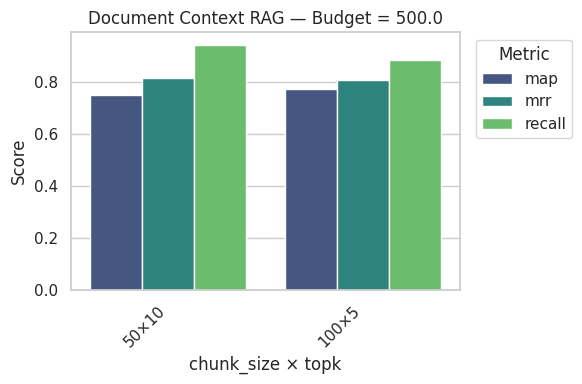

/tmp/ipykernel_830018/1554116880.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


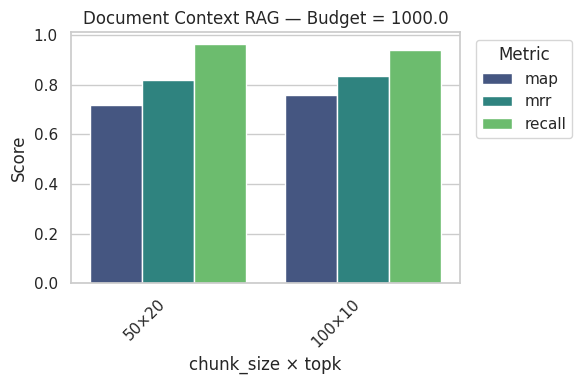

/tmp/ipykernel_830018/1554116880.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


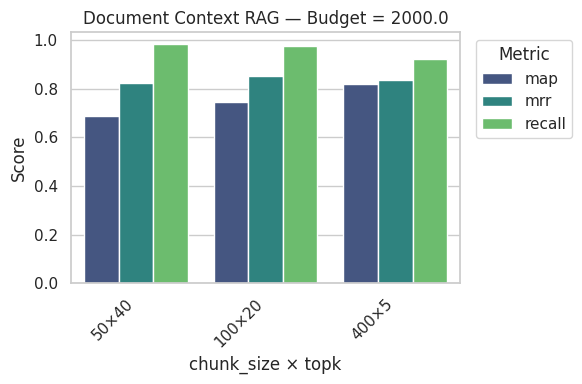

/tmp/ipykernel_830018/1554116880.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


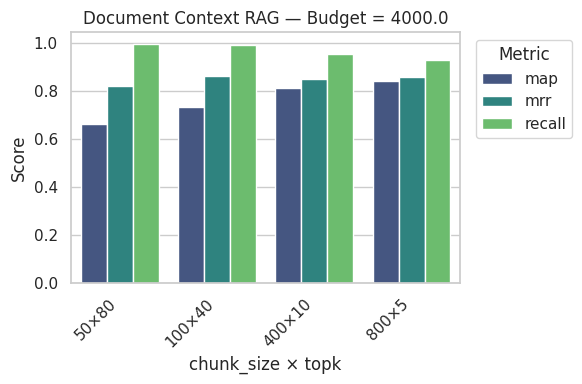

/tmp/ipykernel_830018/1554116880.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


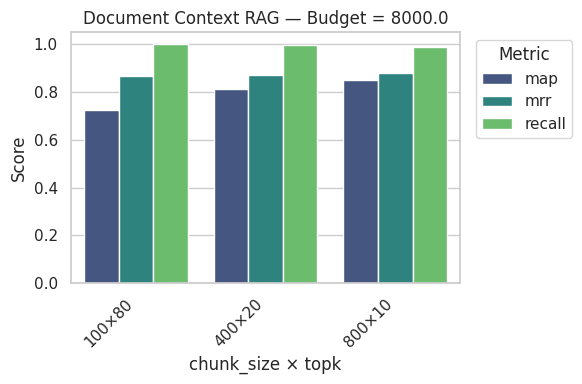

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── assumes you already have `results`:
#     a DataFrame with columns ["splitting","topk","rag_type","metric","score"]

# 1) parse chunk_size and compute budget = chunk_size * topk
def parse_chunk_size(s: str):
    parts = s.split("_")
    if parts[0].lower() == "word":
        return int(parts[1])
    return None

df = results.copy()
df["chunk_size"] = df["splitting"].apply(parse_chunk_size)
df["budget"]     = df["chunk_size"] * df["topk"]

# 2) filter to Contextual RAG + valid chunk sizes (keep all metrics)
df_ctx = df[
    df["rag_type"].str.lower().str.contains("contextual") &
    df["chunk_size"].notna()
]

# 3) find budgets with more than one chunk×topk combo
budget_counts = df_ctx.groupby("budget")["splitting"].nunique()
valid_budgets = budget_counts[budget_counts > 1].index.sort_values()
print("Budgets to plot:", list(valid_budgets))

# 4) for each budget, plot a grouped‐bar chart of MAP, MRR, Recall
for budget in valid_budgets:
    df_b = df_ctx[df_ctx["budget"] == budget].copy()
    # create labels like "50×10", "100×5", etc.
    df_b["label"] = df_b["chunk_size"].astype(int).astype(str) \
                  + "×" + df_b["topk"].astype(int).astype(str)

    # determine x‐order by ascending chunk_size
    order_labels = (
        df_b
        .sort_values("chunk_size")["label"]
        .unique()
        .tolist()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df_b,
        x="label",
        y="score",
        hue="metric",
        order=order_labels,       # ensures smallest chunk first
        palette="viridis",
        ci=None
    )
    plt.title(f"Document Context RAG — Budget = {budget}")
    plt.xlabel("chunk_size × topk")
    plt.ylabel("Score")
    plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [3]:
import glob
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

all_dfs = []

for fp in glob.glob(PATTERN):
    print(f"Processing: {fp}")
    df = pd.read_pickle(fp)
    print("  Columns:", list(df.columns))
    
    # Find Contextual RAG columns
    contextual_cols = [col for col in df.columns if col.startswith("Basic RAG_")]
    print("  Contextual cols:", contextual_cols)
    
    if not contextual_cols:
        print("  Skipping because no contextual columns found.")
        continue
    
    if "variant" not in df.columns:
        print("  Skipping because 'variant' column not found.")
        continue
    
    # Extract Top-K from file name
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    topk = int(m.group(1)) if m else None
    
    sub_df = df[contextual_cols + ["variant"]].copy()
    sub_df["source_file"] = os.path.basename(fp)
    sub_df["topk"] = topk
    all_dfs.append(sub_df)

print(f"\n✅ Loaded {len(all_dfs)} DataFrames.")

if not all_dfs:
    print("❌ No data loaded. Check your patterns or column names.")
else:
    contextual_data = pd.concat(all_dfs, ignore_index=True)
    print(f"✅ contextual_data shape: {contextual_data.shape}")

    # Melt into long format
    melted = contextual_data.melt(
        id_vars=["variant", "source_file", "topk"],
        var_name="metric",
        value_name="score"
    )

    # Clean metric names
    melted["metric"] = melted["metric"].str.replace("Contextual RAG_", "")
    
    melted = melted.dropna(subset=["score"])
    print(melted.head())

Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_20.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall']
Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_5.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr',

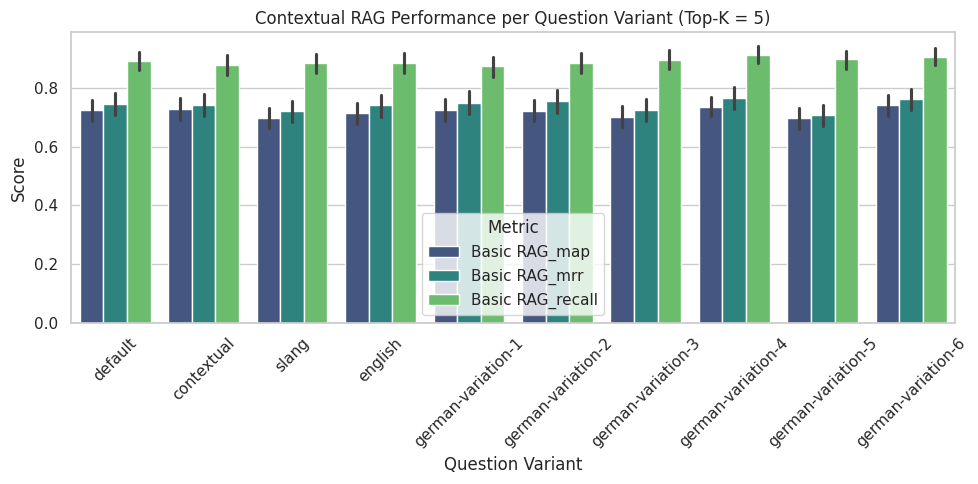

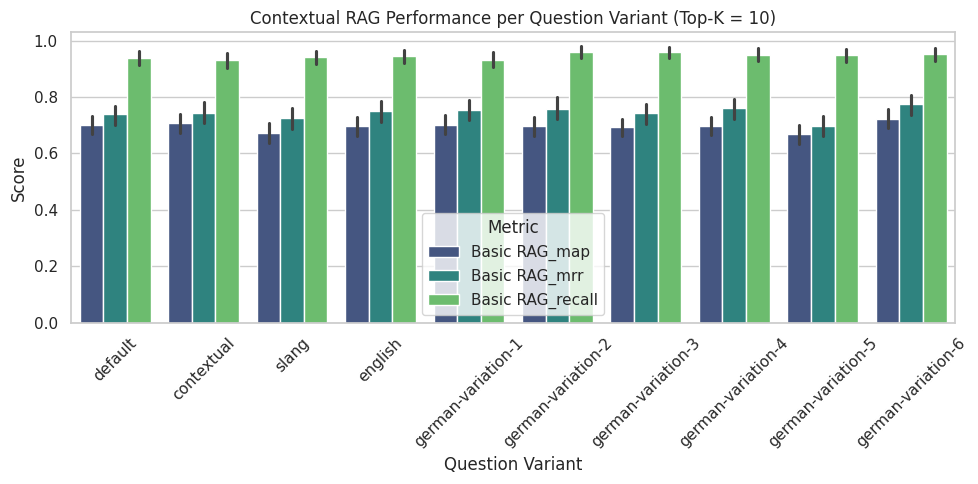

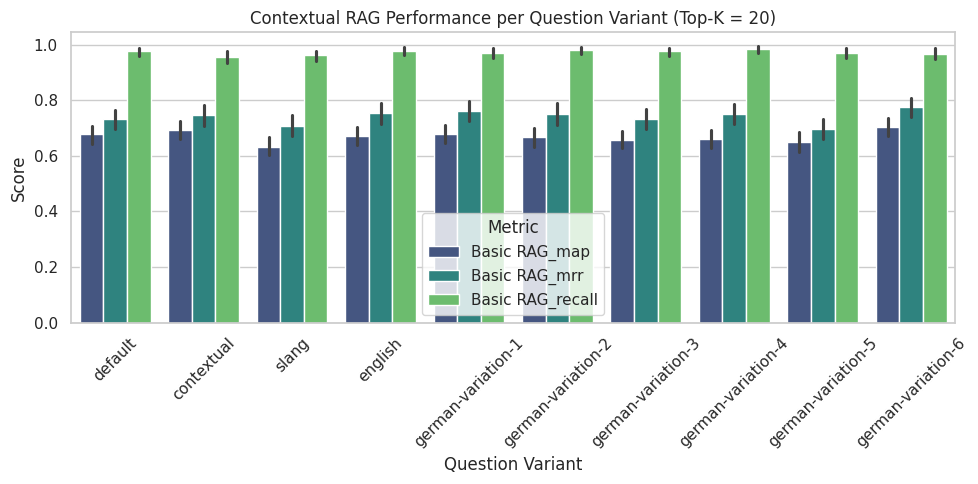

In [4]:
for tk in sorted(melted["topk"].unique()):
    subset = melted[melted["topk"] == tk]

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=subset,
        x="variant",
        y="score",
        hue="metric",
        estimator="mean",
        errorbar="ci",
        palette="viridis"
    )
    plt.title(f"Contextual RAG Performance per Question Variant (Top-K = {tk})")
    plt.ylabel("Score")
    plt.xlabel("Question Variant")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

In [3]:
import glob
import os
import pandas as pd
import re

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

contextual_questions = []

for fp in glob.glob(PATTERN):
    df = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue
    
    if "question" not in df.columns:
        continue

    # Filter only contextual rows
    sub_df = df[df["variant"] == "contextual"]

    if not sub_df.empty:
        # Optionally track the file the questions came from
        for q in sub_df["question"]:
            contextual_questions.append({
                "source_file": os.path.basename(fp),
                "question": q
            })

# Convert to DataFrame for pretty printing (optional)
contextual_df = pd.DataFrame(contextual_questions)

if contextual_df.empty:
    print("No contextual questions found.")
else:
    # Print all contextual questions
    print("✅ Contextual Questions:\n")
    for idx, row in contextual_df.iterrows():
        print(f"- ({row['source_file']}) {row['question']}")

✅ Contextual Questions:

- (topk_20.pkl) Und wie lange dauert dieser Eingriff normalerweise?
- (topk_20.pkl) Ja, der Arzt hat gesagt, das Baby liegt in Beckenendlage. Kann man die Wendung dann sofort versuchen oder muss ich noch warten?
- (topk_20.pkl) Könnte so ein Risiko auch bedeuten, dass dann ein Kaiserschnitt notwendig wird?
- (topk_20.pkl) Sind diese Methoden denn sicher und werden sie oft in Krankenhäusern angewendet?
- (topk_20.pkl) Und wie erkennt man genau, ob solche Komplikationen vorliegen?
- (topk_20.pkl) Beeinflussen bestimmte Risikofaktoren die Erfolgschancen bei meinem Fall?
- (topk_20.pkl) Gibt es Möglichkeiten, die Schmerzen während der Wendung zu verringern?
- (topk_20.pkl) Wird dann sofort ein Kaiserschnitt gemacht oder gibt es noch andere Möglichkeiten?
- (topk_20.pkl) Gibt es dann besondere Risiken für mein Baby bei der Wendung?
- (topk_20.pkl) Ja, der Eingriff ist morgen früh, ab wann darf ich nichts mehr zu mir nehmen?
- (topk_20.pkl) Können diese Atemprobleme 

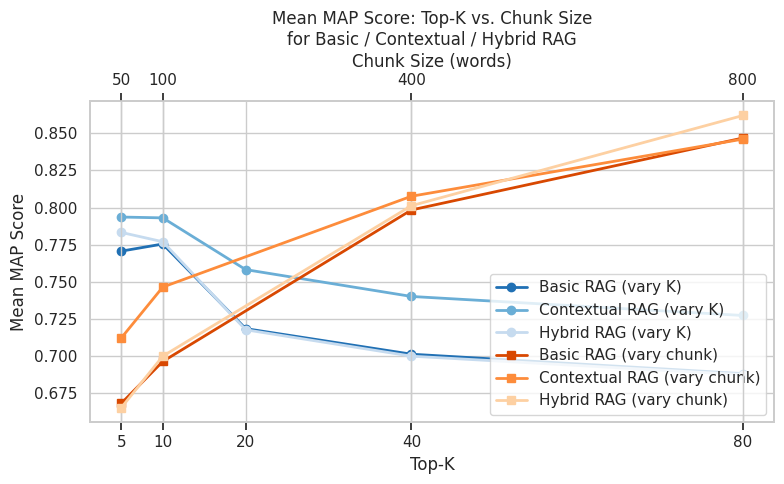

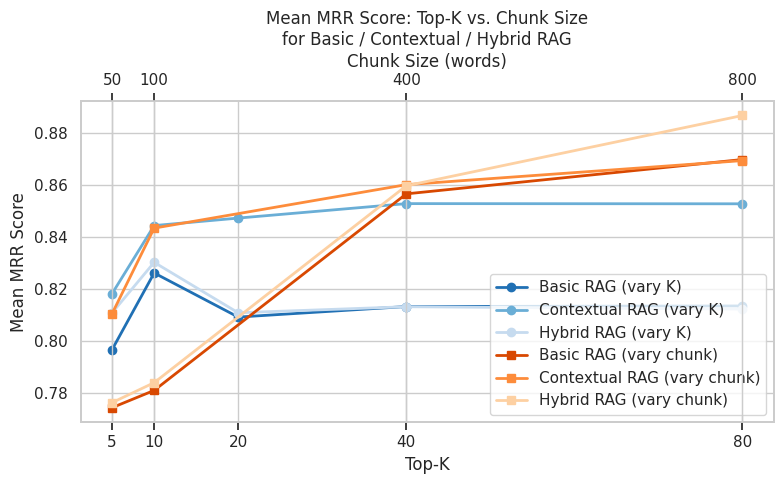

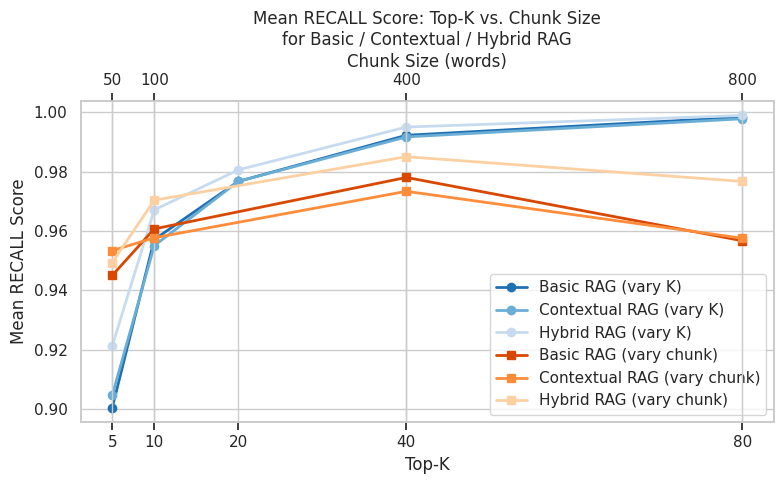

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────────
METRICS   = ["map", "mrr", "recall"]
rag_types = ["Basic RAG", "Contextual RAG", "Hybrid RAG"]
# ─── PREP ──────────────────────────────────────────────────────────────────────

df = (
    results
    .query("rag_type in @rag_types")
    .loc[lambda d: d.splitting.str.startswith("word_")]
    .copy()
)
df["chunk_size"] = df["splitting"].str.extract(r"word_(\d+)_")[0].astype(int)
df["xpos"]       = df["chunk_size"] / 10

topk_palette  = sns.color_palette("Blues",   n_colors=3)[::-1]
chunk_palette = sns.color_palette("Oranges", n_colors=3)[::-1]
topk_colors   = dict(zip(rag_types, topk_palette))
chunk_colors  = dict(zip(rag_types, chunk_palette))

# ─── PLOTTING ───────────────────────────────────────────────────────────────────
for metr in METRICS:
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Bottom axis: vary Top-K (solid ●)
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("topk")["score"].mean().reset_index()
        ax1.plot(
            agg["topk"], agg["score"],
            marker="o",
            color=topk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary K)"
        )
    ax1.set_xlabel("Top-K")
    ax1.set_ylabel(f"Mean {metr.upper()} Score")
    ax1.set_xticks(sorted(df["topk"].unique()))

    # Top axis: vary chunk size (solid ■)
    ax2 = ax1.twiny()
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("xpos")["score"].mean().reset_index()
        ax2.plot(
            agg["xpos"], agg["score"],
            marker="s",
            color=chunk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary chunk)"
        )
    ax2.set_xlabel("Chunk Size (words)")
    xpos = sorted(df["xpos"].unique())
    ax2.set_xticks(xpos)
    ax2.set_xticklabels((pd.Series(xpos) * 10).astype(int).tolist())

    # Combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="lower right")

    plt.title(f"Mean {metr.upper()} Score: Top-K vs. Chunk Size\nfor Basic / Contextual / Hybrid RAG")
    plt.tight_layout()
    plt.show()

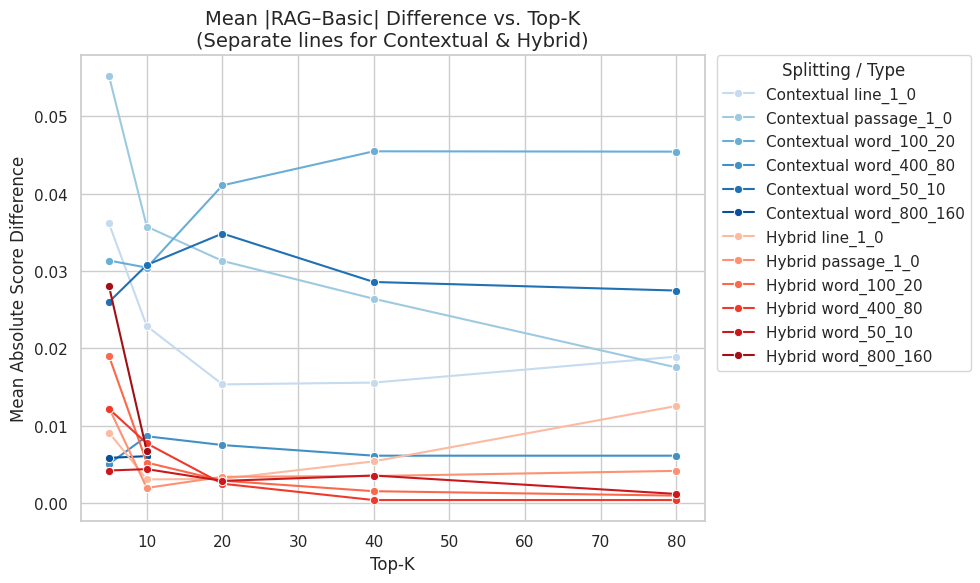

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ─── CONFIG ────────────────────────────────────────────────
METRICS    = ["map","mrr","recall"]
splittings = sorted(results["splitting"].unique())
sns.set(style="whitegrid")

# ─── 0) Pivot long → wide, so we have basic/contextual/hybrid columns ─────────
wide = (
    results
      .pivot_table(
         index=["splitting","topk"],
         columns=["rag_type","metric"],
         values="score"
      )
)
wide.columns = [f"{rt}_{m}" for rt, m in wide.columns]  # flatten
wide = wide.reset_index()

# ─── 1) Compute diff_contextual_<m> & diff_hybrid_<m> ───────────────────────
for m in METRICS:
    wide[f"diff_contextual_{m}"] = (
        wide[f"Contextual RAG_{m}"] - wide[f"Basic RAG_{m}"]
    )
    wide[f"diff_hybrid_{m}"] = (
        wide[f"Hybrid RAG_{m}"]     - wide[f"Basic RAG_{m}"]
    )

# ─── 2) Melt out all the diffs and extract type ──────────────────────────────
diff_cols = [c for c in wide.columns if c.startswith("diff_")]
df_diff = (
    wide
      .melt(
         id_vars=["splitting","topk"],
         value_vars=diff_cols,
         var_name="diff_metric",
         value_name="diff_score"
      )
      .dropna(subset=["diff_score"])
)
# pull out “contextual” vs “hybrid”
df_diff["diff_type"] = df_diff["diff_metric"].str.extract(r"diff_(contextual|hybrid)_")
df_diff["abs_diff"]  = df_diff["diff_score"].abs()

# ─── 3) Aggregate across metrics ─────────────────────────────────────────────
agg = (
    df_diff
      .groupby(["topk","diff_type","splitting"])["abs_diff"]
      .mean()
      .reset_index()
)

# build a grouping key for the legend
agg["group"] = agg["diff_type"].str.title() + " " + agg["splitting"]

# ─── 4) Build a palette: 6 blues for contextual, 6 reds for hybrid ──────────
blues = sns.color_palette("Blues",  len(splittings)+1)[1:]  # skip the palest
reds  = sns.color_palette("Reds",   len(splittings)+1)[1:]

palette = {}
for i, s in enumerate(splittings):
    palette[f"Contextual {s}"] = blues[i]
    palette[f"Hybrid {s}"]     = reds[i]

# ─── 5) Plot all 12 lines ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(
    data=agg,
    x="topk",
    y="abs_diff",
    hue="group",
    palette=palette,
    marker="o",
    ax=ax
)

ax.set_title("Mean |RAG–Basic| Difference vs. Top-K\n(Separate lines for Contextual & Hybrid)", fontsize=14)
ax.set_xlabel("Top-K")
ax.set_ylabel("Mean Absolute Score Difference")
ax.legend(title="Splitting / Type", bbox_to_anchor=(1.02,1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

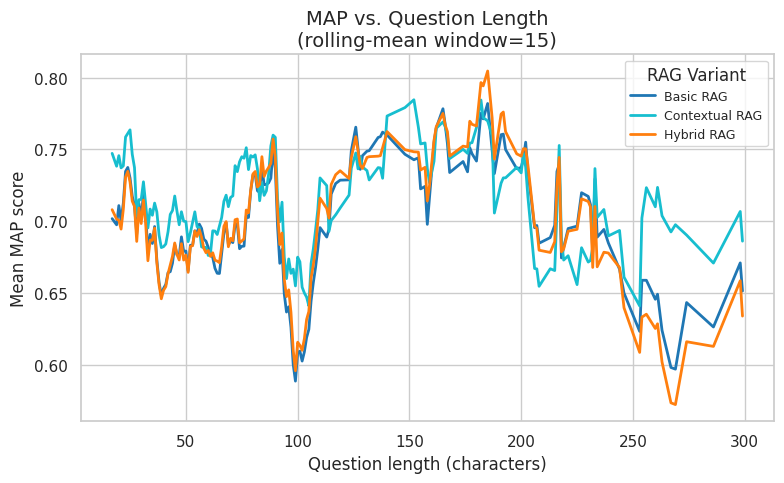

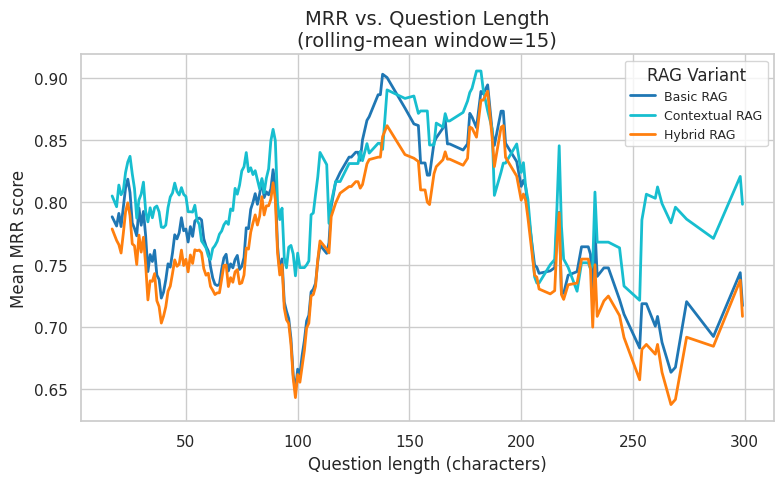

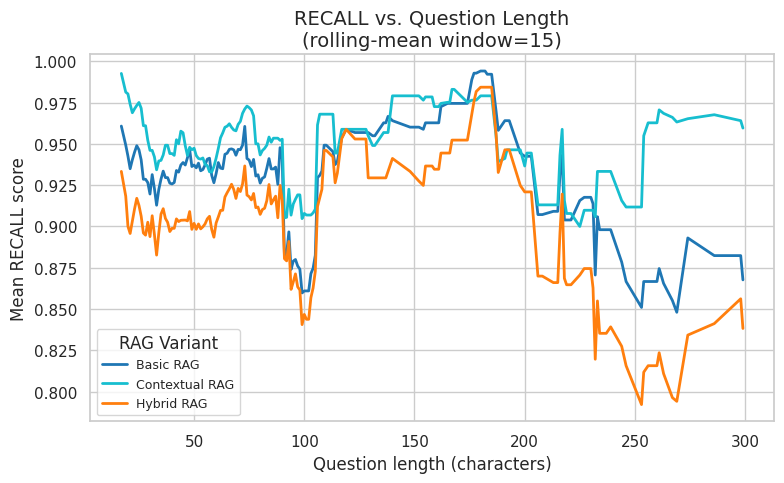

In [6]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ───────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-28_12-33-49/QwenQwen3-Embedding-4B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map","mrr","recall"]
sns.set(style="whitegrid")
# ─── BUILD `long` AS BEFORE ────────────────────────────────────────────
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    df = pd.read_pickle(fp)

    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{m}" in df.columns for m in METRICS))

    for p in prefixes:
        for m in METRICS:
            col = f"{p}_{m}"
            if col not in df: 
                continue
            series = (
                df[col]
                  .dropna()
                  .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
                  .astype(float)
            )
            for q, score in zip(df["question"], series):
                records.append({
                    "rag_type": p,            # e.g. "Basic RAG","Contextual RAG","Hybrid RAG","Random"
                    "metric"  : m,
                    "char_len": len(q),
                    "score"   : score
                })

long = pd.DataFrame(records)

# ─── AGGREGATE & FILTER OUT RANDOM ────────────────────────────────────────
agg2 = (
    long
    .groupby(["char_len","rag_type","metric"])["score"]
    .mean()
    .reset_index()
)
agg2 = agg2[agg2.rag_type != "Random"]  # drop the Random variant

# ─── PALETTE (no Random) & SMOOTHING WINDOW ─────────────────────────────
palette = {
    "Basic RAG"     : "tab:blue",
    "Contextual RAG": "tab:cyan",
    "Hybrid RAG"    : "tab:orange",
}
SMOOTH_WINDOW = 15

# ─── PLOT ONE SMOOTHED LINE PER RAG VARIANT ──────────────────────────────
for metric in METRICS:
    dfm = agg2[agg2.metric == metric]
    fig, ax = plt.subplots(figsize=(8,5))

    for rag_type, sub in dfm.groupby("rag_type"):
        sub = sub.sort_values("char_len")
        sub["smooth_score"] = (
            sub["score"]
            .rolling(window=SMOOTH_WINDOW, min_periods=1, center=True)
            .mean()
        )
        ax.plot(
            sub["char_len"],
            sub["smooth_score"],
            label=rag_type,
            color=palette[rag_type],
            linewidth=2
        )

    ax.set_title(f"{metric.upper()} vs. Question Length\n(rolling‐mean window={SMOOTH_WINDOW})", fontsize=14)
    ax.set_xlabel("Question length (characters)")
    ax.set_ylabel(f"Mean {metric.upper()} score")
    ax.legend(title="RAG Variant", loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_948180/1788418171.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


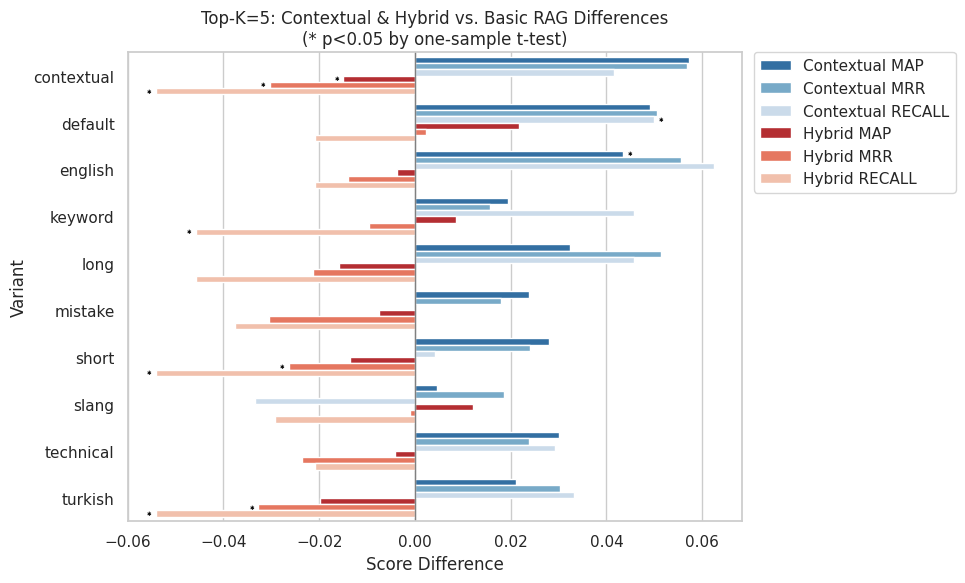

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import os
import glob
import re

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-28_12-33-49/QwenQwen3-Embedding-4B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map", "mrr", "recall"]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

def mean_col(s: pd.Series) -> float:
    """Flatten singleton lists/tuples then take float-mean."""
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list,tuple)) and len(x)==1 else x)
         .astype(float)
    )
    return clean.mean()

# 1) Gather everything into one DataFrame of per-variant scores
records = []
for fp in glob.glob(PATTERN):
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue

    for variant, grp in df.groupby("variant"):
        rec = {
            "variant": variant,
            "topk"   : topk,
        }
        # for each metric, grab Basic/Contextual/Hybrid
        for metric in METRICS:
            for kind in ["Basic RAG", "Contextual RAG", "Hybrid RAG"]:
                col = f"{kind}_{metric}"
                rec[f"{kind.replace(' ', '_').lower()}_{metric}"] = (
                    mean_col(grp[col]) if col in grp.columns else np.nan
                )
        records.append(rec)

results = pd.DataFrame(records)

# 2) Compute differences vs Basic
for metric in METRICS:
    results[f"diff_contextual_{metric}"] = (
        results[f"contextual_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )
    results[f"diff_hybrid_{metric}"] = (
        results[f"hybrid_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )

# Keep ordering
variants = sorted(results["variant"].unique())
topks    = sorted(results["topk"].unique())

# 3) Melt into long form for easy plotting
diff_cols = [f"diff_contextual_{m}" for m in METRICS] + \
            [f"diff_hybrid_{m}"   for m in METRICS]

melted = (
    results
    .melt(
        id_vars=["variant", "topk"],
        value_vars=diff_cols,
        var_name="diff_type_metric",
        value_name="diff_score"
    )
    .dropna(subset=["diff_score"])
)
# split into two columns: diff_type (contextual/hybrid) and metric
melted[["diff_type","metric"]] = (
    melted["diff_type_metric"]
      .str
      .extract(r"diff_(contextual|hybrid)_(.*)")
)



# 1) Prepare data
sub = (
    melted
    .query("topk == 5 and diff_type in ['contextual','hybrid']")
    .copy()
)
sub['diff_type'] = sub['diff_type'].str.title()
sub['metric']    = sub['metric'].str.upper()
sub['key']       = sub['diff_type'] + ' ' + sub['metric']

# 2) Compute significance
sig = {}
for (variant, dt, metr), grp in sub.groupby(['variant','diff_type','metric']):
    _, p = ttest_1samp(grp['diff_score'], 0)
    sig[(variant, dt, metr)] = (p < 0.05)

# 3) Build palette & hue_order
metrics   = ["MAP","MRR","RECALL"]
blues  = sns.color_palette("Blues",  3)[::-1]
reds   = sns.color_palette("Reds",   3)[::-1]

palette = {f"Contextual {m}": blues[i] for i,m in enumerate(metrics)}
palette.update({f"Hybrid {m}": reds[i]     for i,m in enumerate(metrics)})

hue_order = [f"Contextual {m}" for m in metrics] + [f"Hybrid {m}" for m in metrics]
variants  = sorted(sub['variant'].unique())

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=sub,
    y="variant",
    x="diff_score",
    hue="key",
    hue_order=hue_order,
    palette=palette,
    ci=None,
    order=variants,
    ax=ax
)

# zero‐line
ax.axvline(0, color="gray", linewidth=1)

# annotate significance per container (hue)
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]             # e.g. "Contextual MAP"
    dt, metr = key.split()               # "Contextual","MAP"
    metr = metr.upper()

    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]      # same order as y-axis
        if not sig.get((variant, dt, metr), False):
            continue

        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2

        # small offset in points
        dx = 3 if x >= 0 else -3

        ax.annotate(
            "✱",
            xy=(x, y),
            xytext=(dx, 0),
            textcoords="offset points",
            ha="left" if x >= 0 else "right",
            va="center",
            fontsize=4,
            color="black"
        )

# move legend outside
ax.legend(
    title="",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

ax.set_title(
    "Top-K=5: Contextual & Hybrid vs. Basic RAG Differences\n"
    "(* p<0.05 by one-sample t-test)"
)
ax.set_xlabel("Score Difference")
ax.set_ylabel("Variant")

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # make room for the legend
plt.show()

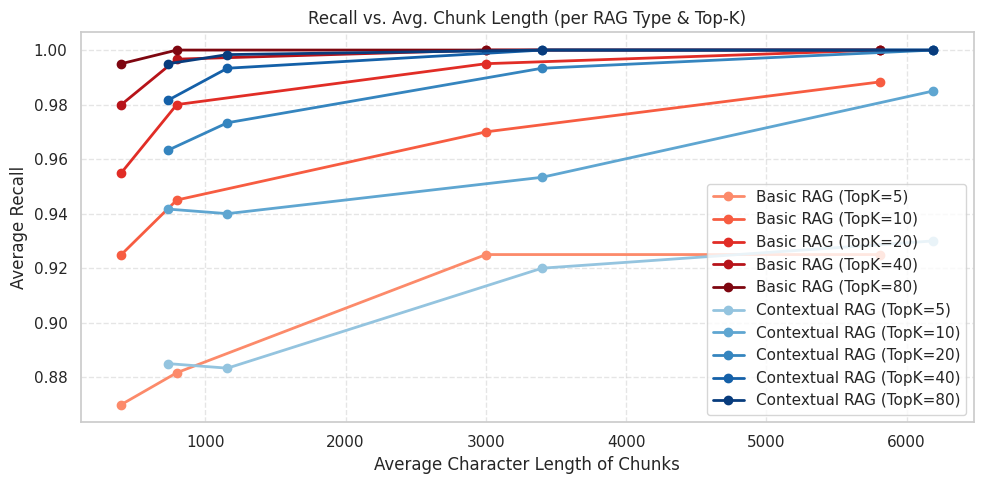

In [37]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from haystack.document_stores.in_memory import InMemoryDocumentStore

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
RESULTS_DIR     = "results/retrieval/2025-07-04_15-42-39/QwenQwen3-Embedding-4B"
PATTERN_RESULTS = os.path.join(RESULTS_DIR, "docs_*", "topk_*.pkl")

DOCSTORE_BASE   = "data/document_stores/Qwen/Qwen3-Embedding-4B/base"
DOCSTORE_CTX    = "data/document_stores/Qwen/Qwen3-Embedding-4B/context"
# ────────────────────────────────────────────────────────────────────────────────


# STEP 1 ── Load avg_char_len from basic and contextual folders
char_records = []

# 1a: BASIC RAG: each store lives under /base/docs_<split>/
for store_dir in glob.glob(os.path.join(DOCSTORE_BASE, "docs_*")):
    split = os.path.basename(store_dir)
    split = re.sub(r"^docs_", "", split)
    split = re.sub(r"_indexing_store\.json$", "", split)
    try:
        store = InMemoryDocumentStore.load_from_disk(store_dir)
        docs = store.filter_documents()
    except Exception as e:
        print(f"⚠ Skipping {store_dir} due to error: {e}")
        continue

    lengths = [len(d.content) for d in docs if hasattr(d, "content")]
    if lengths:
        char_records.append({
            "rag_type": "basic",
            "splitting": split,
            "avg_char_len": sum(lengths) / len(lengths)
        })

# 1b: CONTEXTUAL RAG: under /context/<model>/docs_<split>/
model_dir = os.path.join(DOCSTORE_CTX, "gemma3:12b")
for store_dir in glob.glob(os.path.join(model_dir, "docs_*")):
    split = os.path.basename(store_dir)
    split = re.sub(r"^docs_", "", split)
    split = re.sub(r"_indexing_store\.json$", "", split)
    try:
        store = InMemoryDocumentStore.load_from_disk(store_dir)
        docs = store.filter_documents()
    except Exception as e:
        print(f"⚠ Skipping {store_dir} due to error: {e}")
        continue

    lengths = [len(d.content) for d in docs if hasattr(d, "content")]
    if lengths:
        char_records.append({
            "rag_type": "contextual",
            "splitting": split,
            "avg_char_len": sum(lengths) / len(lengths)
        })

char_df = pd.DataFrame(char_records)
if char_df.empty:
    raise RuntimeError("No document stores could be loaded!")

# STEP 2 ── Load recall values per topk
recall_records = []
prefix_map = {
    "Basic RAG": "basic",
    "Contextual RAG": "contextual"
}
found_prefixes = set()

for fp in glob.glob(PATTERN_RESULTS):
    split = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    df = pd.read_pickle(fp)
    topk = int(re.search(r"topk_(\d+)\.pkl$", fp).group(1))

    for col in df.columns:
        if col.endswith("_recall"):
            prefix = col.removesuffix("_recall")
            found_prefixes.add(prefix)
            if prefix not in prefix_map:
                continue
            rag_type = prefix_map[prefix]
            recall_records.append({
                "rag_type": rag_type,
                "splitting": split,
                "topk": topk,
                "recall": df[col].dropna().astype(float).mean()
            })

if not recall_records:
    raise RuntimeError(f"No *_recall columns found. Discovered: {found_prefixes}")

recall_df = pd.DataFrame(recall_records)

# Normalize split names
for df in [char_df, recall_df]:
    df["splitting"] = df["splitting"].str.strip().str.lower()
    df["rag_type"] = df["rag_type"].str.strip().str.lower()

# STEP 3 ── Merge and filter
plot_df = (
    recall_df
    .merge(char_df, on=["rag_type", "splitting"], how="inner")
    .query("splitting.str.startswith('word_')", engine="python")
    .sort_values("avg_char_len")
)

# STEP 4 ── Plot one line per top-k + rag type
plt.figure(figsize=(10, 5))

# Create color maps
reds  = [cm.Reds(i) for i in np.linspace(0.4, 0.95, 5)]
blues = [cm.Blues(i) for i in np.linspace(0.4, 0.95, 5)]

# Sort topks to keep color order consistent
topk_order = sorted(plot_df["topk"].unique())
topk_to_idx = {tk: i for i, tk in enumerate(topk_order)}

for (rag_type, topk), group in plot_df.groupby(["rag_type", "topk"]):
    idx = topk_to_idx[topk]
    if rag_type == "basic":
        color = reds[idx]
    else:
        color = blues[idx]

    label = f"{rag_type.capitalize()} RAG (TopK={topk})"
    plt.plot(
        group["avg_char_len"],
        group["recall"],
        marker="o",
        linewidth=2,
        color=color,
        label=label
    )

plt.xlabel("Average Character Length of Chunks")
plt.ylabel("Average Recall")
plt.title("Recall vs. Avg. Chunk Length (per RAG Type & Top-K)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
print("🔍 Splits from document stores:")
print(char_df[["rag_type", "splitting"]].sort_values(["rag_type", "splitting"]))

print("\n📊 Splits from recall pickles:")
print(recall_df[["rag_type", "splitting"]].sort_values(["rag_type", "splitting"]))

🔍 Splits from document stores:
      rag_type     splitting
3        basic      line_1_0
0        basic   passage_1_0
1        basic   word_100_20
4        basic   word_400_80
2        basic    word_50_10
5        basic  word_800_160
9   contextual      line_1_0
15  contextual      line_1_0
6   contextual   passage_1_0
12  contextual   passage_1_0
7   contextual   word_100_20
13  contextual   word_100_20
10  contextual   word_400_80
16  contextual   word_400_80
8   contextual    word_50_10
14  contextual    word_50_10
11  contextual  word_800_160
17  contextual  word_800_160

📊 Splits from recall pickles:
      rag_type     splitting
0        basic      line_1_0
1        basic   passage_1_0
2        basic   word_100_20
3        basic   word_400_80
4        basic    word_50_10
5        basic  word_800_160
6   contextual      line_1_0
7   contextual   passage_1_0
8   contextual   word_100_20
9   contextual   word_400_80
10  contextual    word_50_10
11  contextual  word_800_160


## Rewriter

In [1]:
import pandas as pd

df = pd.read_pickle("results/retrieval/rewriter/2025-07-25_16-42-18.pkl")

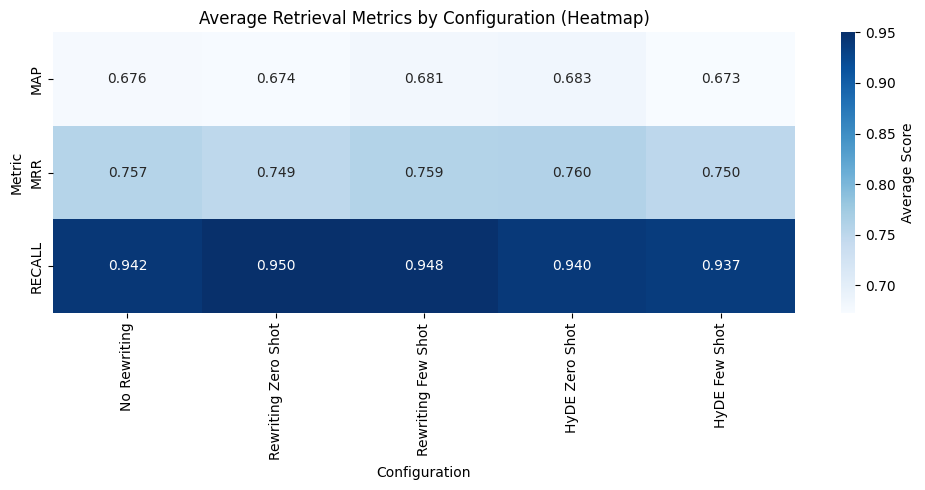

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame if it's not named df
# df = pd.read_csv("your_results.csv")

# Configuration names and metric types
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Create a summary DataFrame with average scores
summary = {
    cfg: [
        df[f"{cfg}_{metric}"].mean() for metric in metrics
    ]
    for cfg in configs
}
summary_df = pd.DataFrame(summary, index=[m.upper() for m in metrics])

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Average Score'})
plt.title("Average Retrieval Metrics by Configuration (Heatmap)")
plt.xlabel("Configuration")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

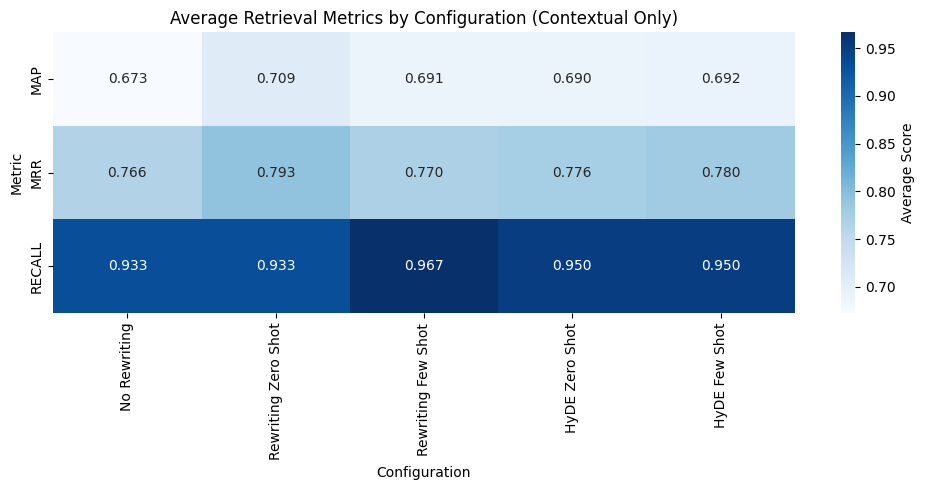

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame if it's not already loaded
# df = pd.read_csv("your_results.csv")

# Filter rows where variant is "contextual"
df_contextual = df[df["variant"] == "contextual"]

# Configuration names and metric types
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Create a summary DataFrame with average scores for contextual rows only
summary = {
    cfg: [
        df_contextual[f"{cfg}_{metric}"].mean() for metric in metrics
    ]
    for cfg in configs
}
summary_df = pd.DataFrame(summary, index=[m.upper() for m in metrics])

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Average Score'})
plt.title("Average Retrieval Metrics by Configuration (Contextual Only)")
plt.xlabel("Configuration")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

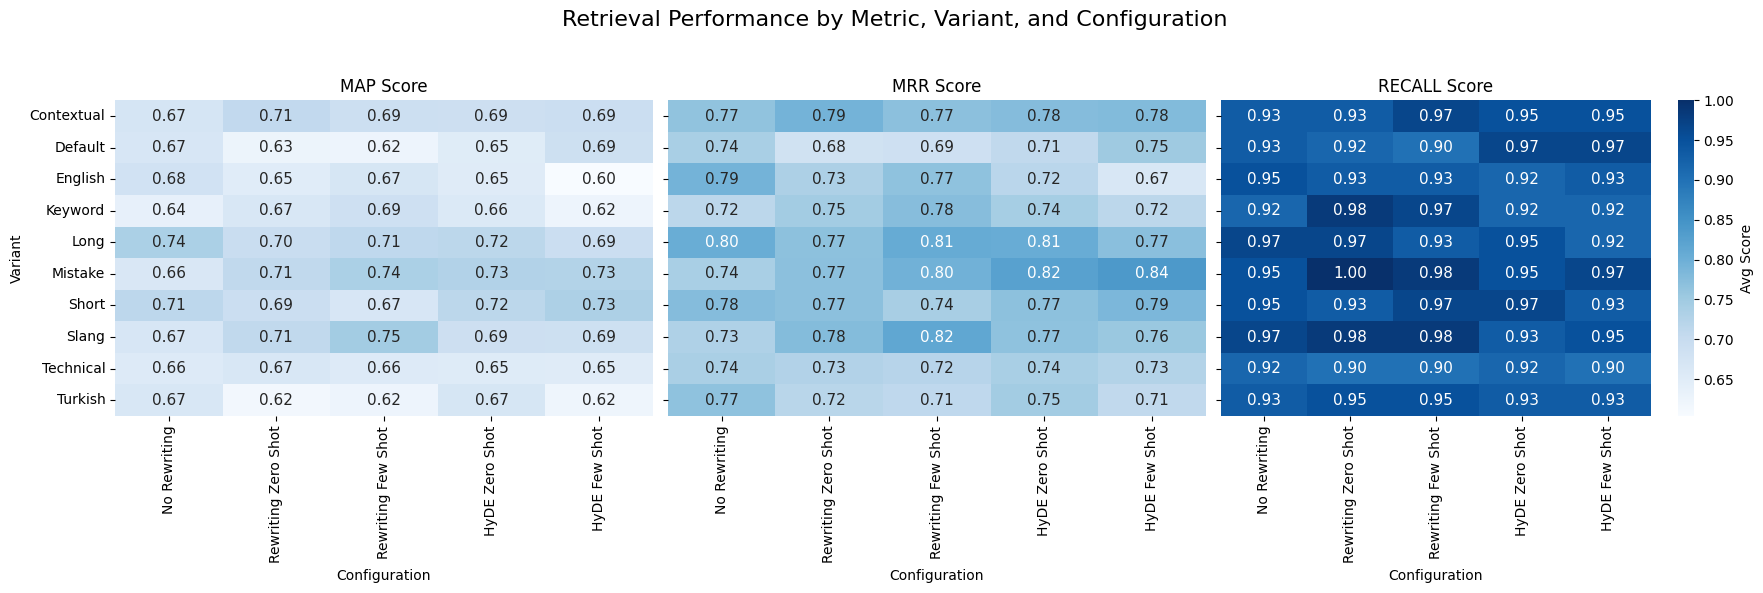

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your actual DataFrame if not already loaded
# df = pd.read_csv("your_results.csv")

# Desired fixed configuration order
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Collect all scores for shared color scale
all_scores = []
heatmap_data_by_metric = {}

for metric in metrics:
    records = []
    for variant in df["variant"].unique():
        df_variant = df[df["variant"] == variant]
        for config in configs:
            col_name = f"{config}_{metric}"
            if col_name in df_variant.columns:
                score = df_variant[col_name].mean()
                all_scores.append(score)
                records.append({
                    "Variant": variant.capitalize(),
                    "Configuration": config,
                    "Score": score
                })
    metric_df = pd.DataFrame(records)
    # Enforce config order as categorical type
    metric_df["Configuration"] = pd.Categorical(metric_df["Configuration"], categories=configs, ordered=True)
    metric_df = metric_df.sort_values(["Variant", "Configuration"])
    heatmap_data_by_metric[metric] = metric_df.pivot(index="Variant", columns="Configuration", values="Score")

# Determine global color scale limits
vmin = min(all_scores)
vmax = max(all_scores)

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.heatmap(
        heatmap_data_by_metric[metric],
        ax=axes[i],
        annot=True,
        fmt=".2f",
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": 11},
        cbar=i == 2,
        cbar_kws={'label': 'Avg Score'} if i == 2 else None
    )
    axes[i].set_title(f"{metric.upper()} Score")
    axes[i].set_xlabel("Configuration")
    if i == 0:
        axes[i].set_ylabel("Variant")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Retrieval Performance by Metric, Variant, and Configuration", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_519170/695464477.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


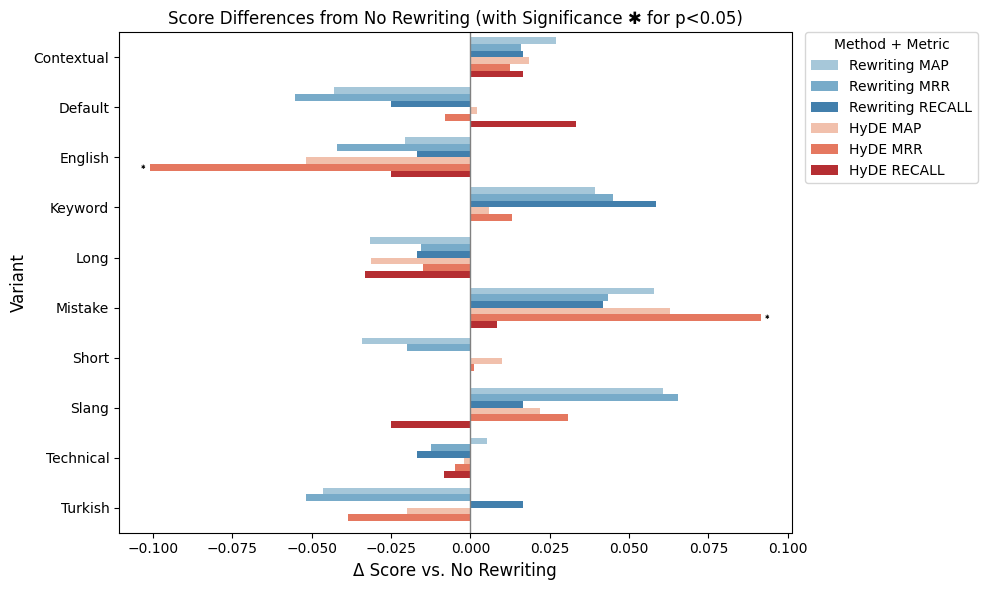

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_1samp

# Replace this with your actual DataFrame if not already loaded
# df = pd.read_csv("your_results.csv")

configs_grouped = {
    "Rewriting": ["Rewriting Zero Shot", "Rewriting Few Shot"],
    "HyDE": ["HyDE Zero Shot", "HyDE Few Shot"]
}
baseline = "No Rewriting"
metrics = ["map", "mrr", "recall"]

# ─── 1) Gather per-row deltas and compute significance ─────────────────────────
records = []
sig = {}  # will hold significance flags keyed by (Variant, Method, Metric)

for variant in df["variant"].unique():
    df_variant = df[df["variant"] == variant]
    variant_label = variant.capitalize()

    for method, configs in configs_grouped.items():
        for metric in metrics:
            baseline_col = f"{baseline}_{metric}"
            # pick only the cfg‐columns that exist
            cfg_cols = [f"{cfg}_{metric}" for cfg in configs if f"{cfg}_{metric}" in df_variant.columns]
            if baseline_col not in df_variant.columns or not cfg_cols:
                continue

            # per‐row baseline and method‐avg
            baseline_vec = df_variant[baseline_col].astype(float)
            method_avg = df_variant[cfg_cols].astype(float).mean(axis=1)

            # compute per‐row difference
            diffs = (method_avg - baseline_vec).dropna()
            if diffs.empty:
                continue

            # mean delta and t-test vs zero
            delta = diffs.mean()
            _, p_val = ttest_1samp(diffs, 0.0)
            is_signif = (p_val < 0.05)

            # record for plotting
            records.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Delta": delta,
                "Label": f"{method} {metric.upper()}"
            })
            sig[(variant_label, method, metric.upper())] = is_signif

plot_df = pd.DataFrame(records)

# ─── 2) Define color palette and plotting order ────────────────────────────────
palette = {
    "Rewriting MAP": "#9ecae1",
    "Rewriting MRR": "#6baed6",
    "Rewriting RECALL": "#3182bd",
    "HyDE MAP":     "#fcbba1",
    "HyDE MRR":     "#fb6a4a",
    "HyDE RECALL":  "#cb181d"
}

# ensure consistent hue order
hue_order = []
for method in configs_grouped:
    for m in ["MAP", "MRR", "RECALL"]:
        key = f"{method} {m}"
        if key in plot_df["Label"].unique():
            hue_order.append(key)

variants = sorted(plot_df["Variant"].unique())

# ─── 3) Create barplot and annotate significance ───────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="Delta",
    y="Variant",
    hue="Label",
    palette=palette,
    hue_order=hue_order,
    order=variants,
    ci=None,
    ax=ax
)

# zero‐line
ax.axvline(0, color="gray", linewidth=1)

# annotate “✱” for p < 0.05
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]          # e.g. "Rewriting MAP"
    method, metr = key.split()        # e.g. ("Rewriting","MAP")
    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]
        if not sig.get((variant, method, metr), False):
            continue
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        # small horizontal offset so the star doesn’t overlap the bar edge
        dx = 3 if x >= 0 else -3
        ax.annotate(
            "✱",
            xy=(x, y),
            xytext=(dx, 0),
            textcoords="offset points",
            ha="left" if x >= 0 else "right",
            va="center",
            fontsize=4,
            color="black"
        )

# ─── 4) Final styling ─────────────────────────────────────────────────────────
ax.set_title("Score Differences from No Rewriting (with Significance ✱ for p<0.05)")
ax.set_xlabel("Δ Score vs. No Rewriting", fontsize=12)
ax.set_ylabel("Variant", fontsize=12)
ax.legend(
    title="Method + Metric", 
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
plt.tight_layout()
plt.show()

In [26]:
# right after the t-test, instead of just saving the boolean, also save the p-value
pvals = []
for variant in df["variant"].unique():
    df_variant = df[df["variant"] == variant]
    variant_label = variant.capitalize()

    for method, configs in configs_grouped.items():
        for metric in metrics:
            baseline_col = f"{baseline}_{metric}"
            cfg_cols = [f"{cfg}_{metric}" for cfg in configs if f"{cfg}_{metric}" in df_variant.columns]
            if baseline_col not in df_variant.columns or not cfg_cols:
                continue

            baseline_vec = df_variant[baseline_col].astype(float)
            method_avg  = df_variant[cfg_cols].astype(float).mean(axis=1)
            diffs        = (method_avg - baseline_vec).dropna()

            if len(diffs) < 2:
                continue

            delta = diffs.mean()
            tstat, p_val = ttest_1samp(diffs, 0.0)
            is_signif = (p_val < 0.05)

            # record for the barplot
            records.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Delta": delta,
                "Label": f"{method} {metric.upper()}"
            })
            sig[(variant_label, method, metric.upper())] = is_signif

            # record for your inspection
            pvals.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Mean Δ": delta,
                "p-value": p_val,
                "Significant?": is_signif
            })

# turn it into a DataFrame and print:
pval_df = pd.DataFrame(pvals)
print(pval_df.sort_values("p-value"))

       Variant     Method  Metric    Mean Δ   p-value  Significant?
22     English       HyDE     MRR -0.091200  0.010396          True
52     Mistake       HyDE     MRR  0.076677  0.041620          True
51     Mistake       HyDE     MAP  0.063151  0.047735          True
12       Slang  Rewriting     MAP  0.060669  0.063690         False
48     Mistake  Rewriting     MAP  0.057851  0.075688         False
26     Keyword  Rewriting  RECALL  0.058333  0.089672         False
13       Slang  Rewriting     MRR  0.065437  0.103254         False
30       Short  Rewriting     MAP -0.034208  0.111163         False
1      Default  Rewriting     MRR -0.055384  0.133813         False
21     English       HyDE     MAP -0.035852  0.137495         False
20     English  Rewriting  RECALL -0.016667  0.159037         False
5      Default       HyDE  RECALL  0.033333  0.159037         False
50     Mistake  Rewriting  RECALL  0.041667  0.167428         False
19     English  Rewriting     MRR -0.042103  0.1

## Reranker Analysis

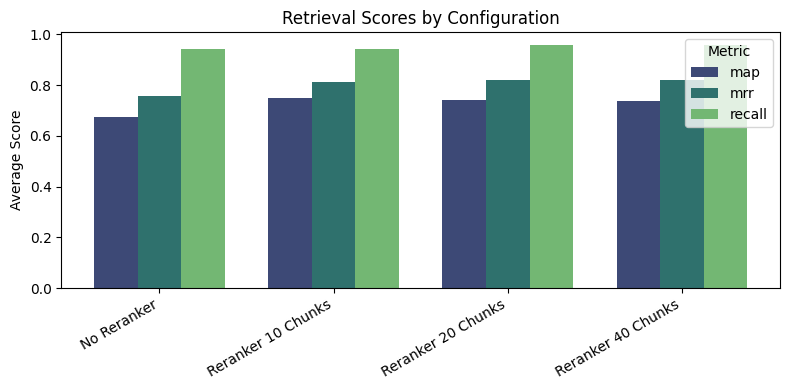

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) Load your DF
df = pd.read_pickle("results/retrieval/reranker/2025-07-25_18-52-35.pkl")

# 2) Find all the *_map, *_mrr, *_recall columns
score_cols = [c for c in df.columns if re.search(r"_(map|mrr|recall)$", c)]

# 3) Compute the mean score for each
mean_scores = df[score_cols].mean()

# 4) Build a clean label for each column
records = []
for col in score_cols:
    m = re.match(r"(?P<model>.+?)_(?P<k>\d+)_(?P<metric>map|mrr|recall)$", col)
    if not m:
        continue
    model, k_str, metric = m.group("model"), m.group("k"), m.group("metric")
    label = "No Reranker" if model == "None" else f"Reranker {k_str} Chunks"
    records.append({
        "label":  label,
        "metric": metric,
        "score":  mean_scores[col]
    })

plot_df = pd.DataFrame(records)

# 5) Collapse duplicates just in case
agg = plot_df.groupby(["label","metric"], as_index=False)["score"].mean()

# 6) Pivot to wide form
pivot = agg.pivot(index="label", columns="metric", values="score")

# 7) Only keep & order the labels you care about
desired = [
    "No Reranker",
    "Reranker 10 Chunks",
    "Reranker 20 Chunks",
    "Reranker 40 Chunks",
    "Reranker 80 Chunks",
]
present = [lbl for lbl in desired if lbl in pivot.index]
pivot = pivot.loc[present]

# 8) Define your custom colors (from your screenshot)
colors = {
    "map":    "#3D4976",   # navy
    "mrr":    "#2F716D",   # teal
    "recall": "#73B773",   # green
}

# 9) Plot
x     = np.arange(len(pivot))
width = 0.25

fig, ax = plt.subplots(figsize=(8,4))
for i, metric in enumerate(pivot.columns):
    ax.bar(
        x + width*i,
        pivot[metric],
        width=width,
        label=metric,
        color=colors[metric]
    )

ax.set_xticks(x + width*(len(pivot.columns)-1)/2)
ax.set_xticklabels(pivot.index, rotation=30, ha="right")
ax.set_ylabel("Average Score")
ax.set_title("Retrieval Scores by Configuration")
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

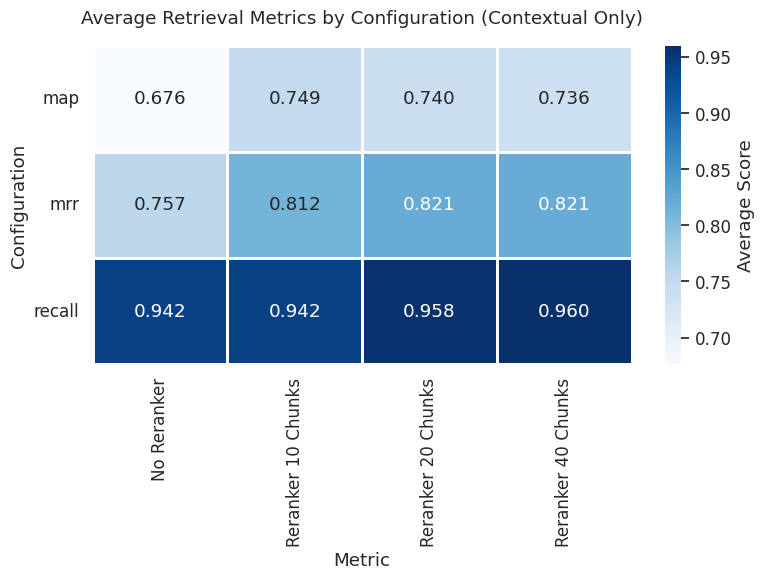

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume `pivot` as before, with index = configurations, columns = [map, mrr, recall]

sns.set(style="white")
sns.set_context("notebook", font_scale=1.1)

fig, ax = plt.subplots(figsize=(8, 6))

# transpose pivot to swap axes
sns.heatmap(
    pivot.T,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    cbar_kws={"label": "Average Score"},
    linewidths=0.8,
    linecolor="white",
    ax=ax
)

# titles and labels
ax.set_title("Average Retrieval Metrics by Configuration (Contextual Only)", pad=16)
ax.set_xlabel("Metric")
ax.set_ylabel("Configuration")

# make x-labels vertical
plt.xticks(rotation=90)
# you can keep y-labels angled if needed
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Closed vs. Open Source

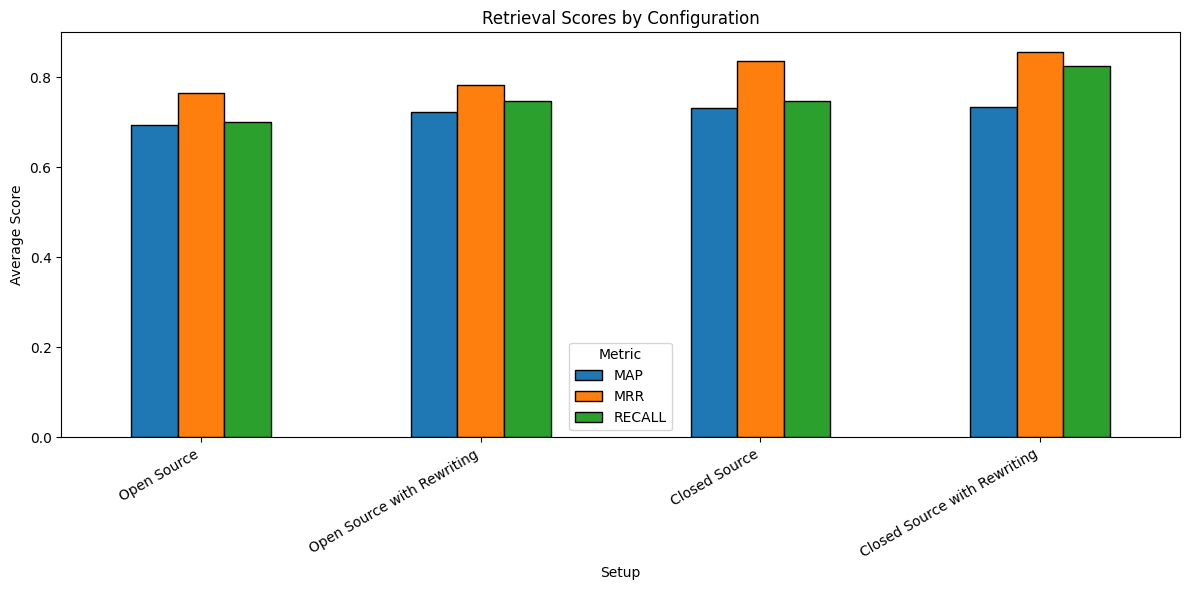

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Load or define your DataFrame ─────────────────────────────────────────────
df = pd.read_pickle("results/retrieval/open_closed_base/2025-07-29_14-30-51/open_closed_result.pkl")
# ────────────────────────────────────────────────────────────────────────────────

# 1) Define your setups & metrics
setups = [
    "Open Source",
    "Open Source with Rewriting",
    "Closed Source",
    "Closed Source with Rewriting"
]
metrics = ["map", "mrr", "recall"]

# 2) Compute mean for each (setup, metric), optionally ignoring 0 & NaN
data = {}
for setup in setups:
    means = []
    for m in metrics:
        col = f"{setup}_{m}"
        # coerce to numeric and turn zeros into NaN so they're skipped in the mean:
        vals = pd.to_numeric(df[col], errors="coerce").replace(0, np.nan)
        means.append(vals.mean())
    data[setup] = means

# 3) Build a “metrics_df” where rows are metrics, columns are setups
metrics_df = pd.DataFrame(
    data,
    index=[m.upper() for m in metrics]
)

# 4) Transpose so each setup becomes a row with three bars
plot_df = metrics_df.T  # now index=setup, columns=['MAP','MRR','RECALL']

# 5) Plot
ax = plot_df.plot(
    kind='bar',
    figsize=(12, 6),
    edgecolor='black'
)
ax.set_title("Retrieval Scores by Configuration")
ax.set_xlabel("Setup")
ax.set_ylabel("Average Score")
ax.set_xticklabels(plot_df.index, rotation=30, ha='right')
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

In [73]:
df.head(20)

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,Open Source_map,Open Source_mrr,Open Source_recall,Open Source with Rewriting_map,Open Source with Rewriting_mrr,Open Source with Rewriting_recall,Closed Source_map,Closed Source_mrr,Closed Source_recall,Closed Source with Rewriting_map,Closed Source with Rewriting_mrr,Closed Source with Rewriting_recall
0,Wie läuft eine äußere Wendung genau ab und was...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,default,[],1.000000,1.000000,1.0,0.333333,0.333333,1.0,0.500000,0.500000,1.0,0.625000,1.000000,1.0
1,Und was passiert dann genau davor?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,contextual,"[Ich habe von der äußeren Wendung gehört, könn...",0.700000,1.000000,1.0,0.833333,1.000000,1.0,0.809524,1.000000,1.0,0.833333,1.000000,1.0
2,Wie genau läuft so ne äußere Wendung ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,slang,[],1.000000,1.000000,1.0,1.000000,1.000000,1.0,0.333333,0.333333,1.0,0.333333,0.333333,1.0
3,How is an external version performed exactly a...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,english,[],0.333333,0.333333,1.0,0.250000,0.250000,1.0,1.000000,1.000000,1.0,0.500000,0.500000,1.0
4,äußere Wendung Ablauf Vorbereitung,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,keyword,[],0.225000,0.250000,1.0,0.183333,0.166667,1.0,0.291667,0.333333,1.0,0.225000,0.250000,1.0
5,Wie läuft eine äußere Wendung ab?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,short,[],0.787500,1.000000,1.0,0.830357,1.000000,1.0,0.839286,1.000000,1.0,0.871111,1.000000,1.0
6,"Können Sie mir bitte ausführlich erklären, wie...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,long,[],1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
7,"Könnten Sie detailliert erläutern, wie eine ex...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,technical,[],0.000000,0.000000,0.0,1.000000,1.000000,1.0,0.000000,0.000000,0.0,1.000000,1.000000,1.0
8,Wie läuft eine äussere Wendung genau ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,mistake,[],0.142857,0.142857,1.0,0.166667,0.166667,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
9,Dış ters döndürme (dış hamle) nasıl yapılır ve...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""